# Artificial Intelligence Nanodegree
## Recurrent Neural Network Projects

Welcome to the Recurrent Neural Network Project in the Artificial Intelligence Nanodegree! In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

# Project 1: Perform time series prediction 

In this project you will perform time series prediction using a Recurrent Neural Network regressor.  In particular you will re-create the figure shown in the notes - where the stock price of Apple was forecasted (or predicted) 7 days in advance.  In completing this exercise you will learn how to construct RNNs using Keras, which will also aid in completing the second project in this notebook.

The particular network architecture we will employ for our RNN is known as  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.  

## 1.1 Getting started

First we must load in our time series - a history of around 140 days of Apple's stock price.  Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1], but it is also commonplace to normalize by a series standard deviation.

In [4]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### load in and normalize the dataset
dataset = np.loadtxt('apple_prices.csv')
scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset.reshape(-1,1))

Lets take a quick look at the (normalized) time series we'll be performing predictions on.

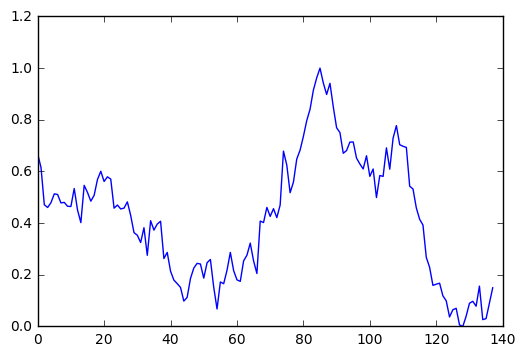

In [5]:
# lets take a look at our time series
plt.plot(dataset)

## 1.2  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$y_{0},y_{1},y_{2},...,y_{P}$$

where $y_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

TIME SERIES GIF GOES HERE

For example - using a window of size $T=3$ we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \left[y_{0},y_{1},y_{2}\right] & y_{3}\\
\left[y_{1},y_{2},y_{3}\right] & y_{4}\\
\vdots & \vdots\\
\left[y_{P-3},y_{P-2},y_{P-1}\right] & y_{P}
\end{array}$$

Next, in order to apply our RNN and treat the problem as one of regression we need to window the data as described in the introductory notebook.  This means - in short - we want to *window* the data in creating our corresponding input/output sequences.  

**TODO:** Create a function that runs a sliding window along the input series and creates associated input/output pairs.  A skeleton function has been provided for you.  Note that this function should input a) the series and b) the window length, and return the input/output sequences.

In [2]:
### TODO: fill out the function below that transforms the input series and window-size into a set of input/output pairs for use with our RNN model
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    # window data
    count = 0
    for t in range(len(series) - window_size):
        # get input sequence
        temp_in = series[t:t + window_size]
        X.append(temp_in)
        
        # get corresponding target
        temp_target = series[t + window_size]
        y.append(temp_target)
        count+=1
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),)
    
    return X,y

With this function in place apply it to the series in the Python cell below.

In [15]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  This is that once we train our model we have something to test it on (like any regression problem!).  This splitting into training/testing sets is done in the cell below.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [4]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

## 1.3  Building our RNN model

With our dataset loaded in and pre-processed we can now begin setting up our RNN.  We use Keras to quickly build a single hidden layer RNN - where our hidden layer consists of LTSM modules.

Now its your turn to build a simple single-hidden layer RNN with LTSM hidden units, a softmax activation, and mean_squared_error loss function.  This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are using the preferred optimizer (given in the cell below.

In [5]:
### TODO: create required RNN model

# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# fix random seed
np.random.seed(2)

# build model
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model = Sequential()
model.add(Dense(8, input_dim=window_size, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)

Using TensorFlow backend.


With your model built we can now fit the model by activating the cell below! 

In [9]:
# run your model!
model.fit(X_train, y_train, nb_epoch=1000, batch_size=2, verbose=1)

## 1.4  Checking performance

With your model fit we can now make predictions on both our training and testing sets.

In [10]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Activating the next cell plots the original data, as well as both predictions on the training and testing sets.  **Your plot should look very similar to the one given in the notes!**

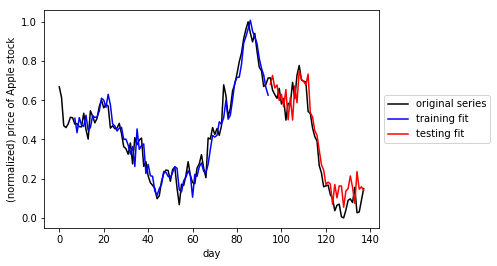

In [11]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

**Note:** you can try use any time series for this exercise!  If you would like to try another see e.g., [this site containing thousands of time series](https://datamarket.com/data/list/?q=provider%3Atsdl) and pick another one!

# Project 2: Create a sequence generator

## 2.1  Getting started

In this project you will implement a popular Recurrent Neural Network (RNN) architecture to create an English language sequence generator capable of building semi-coherent english sentences from scratch by building them up character-by-character.  This will require a substantial amount amount of parameter tuning on a large training corpus (at least 100,000 characters long).  In particular for this project we will be using a complete version of Sir Arthur Conan Doyle's classic book The Adventures of Sherlock Holmes.

**Fun note:** For those interested in how text generation is being used check out some of the following fun resources:

- [Generate wacky sentences](http://www.cs.toronto.edu/~ilya/rnn.html) with this academic RNN text generator

- Various twitter bots that tweet automatically generated text like[this one](http://tweet-generator-alex.herokuapp.com/).

- the [NanoGenMo](https://github.com/NaNoGenMo/2016) annual contest to automatically produce a 50,000+ novel automatically

**Important note:** Tuning RNNs for a typical character dataset like the one we will use here is a computationally intensive endeavour and thus timely on a typical CPU.  Using a reasonably sized cloud-based GPU can speed up training by a factor of 10.  Also because of the long training time it is highly recommended that you carefully write the output of each step of your process to file.  This is so that all of your results are saved even if you close close the web browser you're working out of, as the processes will continue processing in the background but variables/output in the notebook system will not update when you open it again.

In [6]:
### A simple way to write output to file
x = 2   
f = open('my_test_output.txt', 'w')              # create an output file to write too
f.write('this is only a test ' + '\n')           # print some output text
f.write('the value of x is ' + str(x) + '\n')    # record a variable value
f.close()                                        # close the file when everything is recorded

In [51]:
from __future__ import print_function
import numpy as np
import sys
f = open('RNN_seq_gen_output.txt', 'w')              # create an output file to write too

## 2.2  Preprocessing a text dataset

Our first task is to get a large text corpus for use in training, and on it we perform a several light pre-processing tasks.  The default corpus we will use is the classic book Sherlock Holmes, but you can use a variety of others as well - so long as they are fairly large (around 100,000 characters or more).  

In [60]:
# read in the text, transforming everything to lower case
text = open('holmes.txt').read().lower()
print('our original text has ' + str(len(text)) + ' characters')

our original text has 594933 characters


Next, lets examine a bit of the raw text.  Because we are interested in creating sentences of English words automatically by building up each word character-by-character, we only want to train on valid English words.  In other words - we need to remove all of the other junk characters that aren't words!

In [61]:
### print out the first 1000 characters of the raw text to get a sense of what we need to throw out
text[:2000]

"\xef\xbb\xbfproject gutenberg's the adventures of sherlock holmes, by arthur conan doyle\r\n\r\nthis ebook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  you may copy it, give it away or\r\nre-use it under the terms of the project gutenberg license included\r\nwith this ebook or online at www.gutenberg.net\r\n\r\n\r\ntitle: the adventures of sherlock holmes\r\n\r\nauthor: arthur conan doyle\r\n\r\nposting date: april 18, 2011 [ebook #1661]\r\nfirst posted: november 29, 2002\r\n\r\nlanguage: english\r\n\r\n\r\n*** start of this project gutenberg ebook the adventures of sherlock holmes ***\r\n\r\n\r\n\r\n\r\nproduced by an anonymous project gutenberg volunteer and jose menendez\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\nthe adventures of sherlock holmes\r\n\r\nby\r\n\r\nsir arthur conan doyle\r\n\r\n\r\n\r\n   i. a scandal in bohemia\r\n  ii. the red-headed league\r\n iii. a case of identity\r\n  iv. the boscombe valley mystery\r\n   v. the five

Wow - there's a lot of junk here!  e.g., all the carriage return and newline sequences '\n' and '\r' sequences.  We want to train our RNN on a large chunk of real english sentences - we don't want it to start thinking non-english words or strange characters are valid! - so lets clean up the data a bit.

First, since the dataset is so large and the first few hundred characters contain a lot of junk, lets cut it out.  Lets also find-and-replace those newline tags with empty spaces.

In [62]:
### find and replace '\n' and '\r' symbols - replacing them 
text = text[1302:]
text = text.replace('\n',' ')    # replacing '\n' with '' simply removes the sequence
text = text.replace('\r',' ')

Lets see how the first 1000 characters of our text looks now!

In [63]:
### print out the first 1000 characters of the raw text to get a sense of what we need to throw out
text[:1000]

" i have seldom heard  him mention her under any other name. in his eyes she eclipses  and predominates the whole of her sex. it was not that he felt  any emotion akin to love for irene adler. all emotions, and that  one particularly, were abhorrent to his cold, precise but  admirably balanced mind. he was, i take it, the most perfect  reasoning and observing machine that the world has seen, but as a  lover he would have placed himself in a false position. he never  spoke of the softer passions, save with a gibe and a sneer. they  were admirable things for the observer--excellent for drawing the  veil from men's motives and actions. but for the trained reasoner  to admit such intrusions into his own delicate and finely  adjusted temperament was to introduce a distracting factor which  might throw a doubt upon all his mental results. grit in a  sensitive instrument, or a crack in one of his own high-power  lenses, would not be more disturbing than a strong emotion in a  nature such as h

Now its your turn to make sure we haven't left any other non-english characters lurking around in the depths of the text.  You can do this by ennumerating all the text's unique characters, examining them, and then replacing any unwanted (non-english) characters with empty spaces!

In [64]:
# TODO: find all unique characters in the text
a = list(set(text))
print(a)

['\xa8', '\xa9', '!', ' ', '"', '%', '$', "'", '&', ')', '(', '*', '-', ',', '/', '.', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8', ';', ':', '?', '@', '\xc3', '\xa0', '\xa2', 'a', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'h', 'k', 'j', 'm', 'l', 'o', 'n', 'q', 'p', 's', 'r', 'u', 't', 'w', 'v', 'y', 'x', 'z']


Now that you have found all of the text's unique characters, remove all of the non-english ones in the next cell.  Note: don't remove necessary punctuation marks!

In [65]:
# TODO: remove as many non-english characters and character sequences as you can 
non_english = ['\xa8', '\xa9', '"', '%', '$', "'", '&', ')', '(', '*', '-', '/', '1', '0', '3', '2', '5', '4', '7', '6', '9', '8', '?', '@', '\xc3', '\xa0', '\xa2']
for i in non_english:
    text = text.replace(i,'')
text = text.replace('  ',' ')

With your chosen characters removed print out the first few hundred lines again just to double check that everything looks good.

In [66]:
### print out the first 2000 characters of the raw text to get a sense of what we need to throw out
text[:2000]

' i have seldom heard him mention her under any other name. in his eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler. all emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. he was, i take it, the most perfect reasoning and observing machine that the world has seen, but as a lover he would have placed himself in a false position. he never spoke of the softer passions, save with a gibe and a sneer. they were admirable things for the observerexcellent for drawing the veil from mens motives and actions. but for the trained reasoner to admit such intrusions into his own delicate and finely adjusted temperament was to introduce a distracting factor which might throw a doubt upon all his mental results. grit in a sensitive instrument, or a crack in one of his own highpower lenses, would not be more disturbing than a strong emotion in a nature such as his. and yet there wa

Now that we have thrown out a good number of non-English characters/character sequences lets print out some statistics about the dataset - including number of total characters and number of unique characters.

<font color='red'>__COMMENTS/SUGGESTIONS:__ i'm thinking you should just skip into the chapters. like, dump out the first 1000 or so characters with table of contents and other non-sentences. in the code cell below, I would remove "number of" in "total number of characters".  i printed the characters.  what is "\ufeff"?  maybe remove that one...

on removing the string 'ix.' removes the end of sentences like 'fix.', 'six.', etc. 'x.' removes 'tax.' more reliable to just skip past chapters

would also tell them as a shortcut to figure out what kinds of strings are bad they might be able to just print `sorted(list(set(text)))` to check the guess</font>

In [35]:
# count the number of unique characters in the text
chars = sorted(list(set(text)))

# print some of the text, as well as statistics
print ("this corpus has " +  str(len(text)) + " total number of characters")
print ("this corpus has " +  str(len(chars)) + " unique characters")

this corpus has 97427 total number of characters
this corpus has 41 unique characters


The last step:  convert our characters via a look up table into numerical values.  We can't just throw characters into any machine learning algorithm - they only ingest numerical values.  So we need to create a function that transforms each of our input characters into distinct numerical values - like integers.  To do this we make a simple dictionary mapping each unique character to a unique integer.  To re-translate the output of our RNN - which will be a sequence of integers - into our unique set of characters we also create the inverse function dictionary mapping integers back to our unique characters.

In [36]:
### generate function mapping each unique character to a unique integer, as well as its inverse
char_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer
indices_char = dict((i, c) for i, c in enumerate(chars))  # map each unique integer back to unique character

## Cutting our text into sequences

Now we need to cut up the text into equal length sequences.  However it can certainly be the case that a word at the start or end of a sequence might get cut off, so in order to not lose this information we cut up the text in a simiilar manner to how images / audio are cut for classification - via *windowing*.  Imagine the entire text as one long string.  We slide a window of fixed length along the string from left to right - taking a step of a certain number of characters each time - and take a snapshot of whats in the window at each moment.

<font color='red'>__COMMENTS/SUGGESTIONS:__ at some point (just came to mind) might want to clarify that (i cant </font>

In [37]:
### cut the text into sequences
def window_transform_text(text):
    maxlen = 40
    step = 3
    sentences = []
    next_chars = []
    
    # loop over text and cut into sequences
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])

    # create windowed dataset
    X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
        
    return X,y

## Setting up our RNN

With our dataset loaded in and pre-processed we can now begin setting up our RNN.  We use Keras to quickly build a single hidden layer RNN - where our hidden layer consists of LTSM modules.

In [38]:
### necessary functions from the keras library
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import random

Now its your turn to build a simple single-hidden layer RNN with LTSM hidden units, a softmax activation, and categorical_crossentropy loss function.  This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.

<font color='red'>__COMMENTS/SUGGESTIONS:__ maxlen not defined. for code block below with iterations -- Exception: Error when checking model input: expected lstm_input_1 to have 3 dimensions, but got array with shape (131, 7). my code running in tensorflow btw but it looks your yours has theano backend? can mention they can do something like this: https://github.com/genekogan/RobotShakespeare</font>

In [53]:
### TODO build the required RNN model: a single LSTM hidden layer with softmax activation, categorical_crossentropy loss 
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

### UNDER CONSTRUCTION

With our RNN build we can now train our model on the input text data.

In [42]:
# sampling function for RNN-based predictions
def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) 
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [52]:
f = open('RNN_output.txt', 'w')  # create an output file to write too

# train the model, output generated text after each iteration
for iteration in range(1, 50):
    # print update to console
    print()
    print('-' * 40)
    line = 'Iteration ' + str(iteration) + '\n'
    print(line)
    
    # record iteration count
    f.write('-' * 40 + '\n')
    f.write(line)         
    
    # fit model to current batch
    model.fit(X, y, batch_size=128, nb_epoch=1)
    start_index = random.randint(0, len(text) - maxlen - 1)

    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    
    # print update to console and record
    line = 'GENERATING WITHI SEED: "' + sentence + '"' + '\n'
    print(line)
    f.write(line)
    
    # print generated sentece and record
    print(generated + '\n')
    f.write(generated + '\n')

    # print predicted words
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

    # print out next character to command line
    print(generated)
    print('\n')

    # record next character
    f.write(generated)
    f.write('\n')
    f.write('\n')


----------------------------------------
Iteration 1



Exception: Error when checking model input: expected lstm_input_1 to have 3 dimensions, but got array with shape (131, 7)



----------------------------------------
Iteration 1

Epoch 1/1
31707/31707 [==============================] - 82s - loss: 2.5535    
GENERATING WITHI SEED: " by the underground as far as aldersgate"

 by the underground as far as aldersgate

 by the underground as far as aldersgatevex musteot joke  a  o hen mere ih-he, hasler shese ree ther susu yon hadeve c as fimed diveathare ane the custrel menet auln, dat sskezimer thited oun thot"suad wher and dooeedht yout the lis sress af hute so wink nighy merhecr lihemfyor renn thed t e et, u the kger bupent shes, i wuperout he wher we uesesed, whiceshed the sibe ceregebues, but a pit tud, onaos ""itheswoon?"-is, watner. ank wave y



----------------------------------------
Iteration 2

Epoch 1/1
31707/31707 [==============================] - 81s - loss: 2.1084    
GENERATING WITHI SEED: " and found him in deep conversation with"

 and found him in deep conversation with

 and found him in deep conversation witho dant nould norded worn geriacven, aine beming finh thored se iisherss. ank restod, to me youchs. som'ss abbwhon. miching suve outh chield time. "bladg bat hernatls-ffrer. allde did, 'loased and wics pold?""i, his rose, of soll. as has sourd bacefoble."""im and heded well it mo thoant forte warn nats have.'she wulh een."mur in awround."indthe which pock milf in.""iwedbepar.""he cadmyok,' of thatw



----------------------------------------
Iteration 3

Epoch 1/1
31707/31707 [==============================] - 81s - loss: 1.9508    
GENERATING WITHI SEED: "in my occupation, and he shookhis head w"

in my occupation, and he shookhis head w

in my occupation, and he shookhis head witwoge hesuned.""yering bitan witely sued thingo dosbersasedbuperbatuly at in the where yough, thernong coar's wat ofelingly withou man at rea,hadimorisuid."you .thece atsokiency. whenihaind otat upock, a sters,' he watca see in the praces suatrt starrite the reemedyaturengaty seames. the friedd not, the will mer atlank holmes fronced toovers. it the wall dowr ben ank isincaner,. "'ch cauld form n



----------------------------------------
Iteration 4

Epoch 1/1
31707/31707 [==============================] - 81s - loss: 1.9289    
GENERATING WITHI SEED: "yle  a scandal in bohemia i the red-head"

yle  a scandal in bohemia i the red-head

yle  a scandal in bohemia i the red-head, abithed lood, and noch retouk the arespersocced explessad whem are and for selpld thewnlon what yourcowes at the so gia've righter dilares fartherlone that the loptiegle tule onthry noch, are my papeccecaid that mistre on the pad'ss were-compterpapedonny caywas seeinctouteck you towneck thinsced majesely of criers anmyoum treellerdeds do reample! "ow, juart this efissy no pout de thaftuee to may



----------------------------------------
Iteration 5

Epoch 1/1
31707/31707 [==============================] - 81s - loss: 1.7601    
GENERATING WITHI SEED: "me hundreds of times.""then how many are"

me hundreds of times.""then how many are

me hundreds of times.""then how many aremarossh it me. wy pad had thomone to apst shat of seer, but he leaths at his easuratilips of the more id but his visowd the acessed thes se'sing the scis pory, bus a s'mettors."it is beeplense the freelst, if my rerscal a dore it his extention.""was night gis on that hacs, our not my is the whin for thencames oper har od our a shill.t it plcaised rapactbeeftished i mad harkely house. "there adsper



----------------------------------------
Iteration 6

Epoch 1/1
31707/31707 [==============================] - 83s - loss: 1.6643    
GENERATING WITHI SEED: "ven her notice, but there, again, i fail"

ven her notice, but there, again, i fail

ven her notice, but there, again, i faile. to saved so the other amalsange absease ansculy my wo lidstane insothindicling as to cuiteffor, of conserforrich yet onle ady's scatey how mndurstand, shond was ofte bainch. mister, inlorkall devere as teit moroght rush twake tersevestyous," gabez over minuthacriss assteestate yet sethe natestap cair, reagely"nes to thiche, twas to his  andes officminien. you sidgrud of verywhoph you a backatio



----------------------------------------
Iteration 7

Epoch 1/1
31707/31707 [==============================] - 83s - loss: 1.5773    
GENERATING WITHI SEED: "tair, some going up in hope, and some co"

tair, some going up in hope, and some co

tair, some going up in hope, and some could ant youghred allonst the should bat heid all healmyouch might."'the long to to hrowanight alyans your odperanbepos orman, whe half i shilthen misule to befordoacegotheryould beforrow otce conce. "inledge.""wat holmes--it an what mey wall, wenk is aeso lodge my iterfing on than! mery to a strabtertown," said for ie lost, to cotiereachattrest. i had har. not very drown thatof to your hexisence, 



----------------------------------------
Iteration 8

Epoch 1/1
31707/31707 [==============================] - 85s - loss: 1.5016    
GENERATING WITHI SEED: "the office, or at least in thebuilding, "

the office, or at least in thebuilding, 

the office, or at least in thebuilding, "but you while his daftiaspafteeralle, appered that arr us, i through which larey.in under known to bithing your or betined to cisialupt isunt the scometting themoher st. holmes. my situase mecass.""thraid if wout thas indead withouped notion the hhore and doythan yourp bire seary, from havst for for inwill but if this extrent as a becal say breare that mean if i do bethat it of spiked wits with r



----------------------------------------
Iteration 9

Epoch 1/1
31707/31707 [==============================] - 85s - loss: 1.4345    
GENERATING WITHI SEED: "r with you."iat three o'clock precisely "

r with you."iat three o'clock precisely 

r with you."iat three o'clock precisely of so my. "i an. spating out of heard of itsubution to head i ductiove manyontrong."itares. it is encustet in the roor knowded, and you had quein has ducobe his clover."your clostred down eyes.""whyyewwhowa care notwilp.""why, with his flochai hap chair, i want, walsingfor, and i the stoeidsour at thisedred. the acaly. you might the cours and awhave was the lodge ol'mery had an a keen the ,ay is t



----------------------------------------
Iteration 10

Epoch 1/1
31707/31707 [==============================] - 85s - loss: 1.3653    
GENERATING WITHI SEED: " of windingstone steps, which terminated"

 of windingstone steps, which terminated

 of windingstone steps, which terminated an entraterept the would hesled whe hagrthe outhing which the word hend i am theiesives nothingrew crats dar, of which was onrahinl to you was a grasmed and a promaping saing in sundsed and ar stagetar, risher mere from a traye i have seeth it?""te was door as i mastontler agsell an adfrient to sit you crawinnwhops it i had have intrenab-aabole awonswo with her when thebets, i at thear hid foucte



----------------------------------------
Iteration 11

Epoch 1/1
31707/31707 [==============================] - 82s - loss: 1.3162    
GENERATING WITHI SEED: " german who writes upon bohemian paper a"

 german who writes upon bohemian paper a

 german who writes upon bohemian paper and done of a rister. "he had not quite my with theif cous whilh-you cablk mus my it mysirond think, we haviry and fou hourg?""'ye is not threacted of that yet itwas posend folay why har much. the has as a parkacted thought a live been becore ohan, and a king, think, with dutter.with he. "'yet what he had farill was there readed me lers of a chandat clangly my pock-fortil sick to the mores and in t



----------------------------------------
Iteration 12

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.2696    
GENERATING WITHI SEED: " upof the singular tragedy of the atkins"

 upof the singular tragedy of the atkins

 upof the singular tragedy of the atkins at is anyto statter whice heptenclance of leet though of the shoughis atecased andbusined i shouldbeel but tore harglr all remance, mank then should is anmery behinst and have never not coller had keet letters, and occame that, a rany froohh dand which lan upon been upon misn bean proght at house ihen."we are himwerlo halferpecele." it was orman, a learuned is am ever theragst could that he could



----------------------------------------
Iteration 13

Epoch 1/1
31707/31707 [==============================] - 84s - loss: 1.2307    
GENERATING WITHI SEED: " to be a man of strong character,with a "

 to be a man of strong character,with a 

 to be a man of strong character,with a littlecad proway dofrecere as iracted, and le me, be will a beventiveraw i rence." sherlock holmes shopt exfeeverven.""nod the warded twicing of his hands, said thefults of herdedweat suvent in frient. cring rugwill.""bure i wasing ! is alrow all mis headlyon so king dood steel, of farnome was ton the wooke of the himp cas aladsearpenting clutged undinciness teat it."escer ment undant. thebind, an



----------------------------------------
Iteration 14

Epoch 1/1
31707/31707 [==============================] - 84s - loss: 1.3019    
GENERATING WITHI SEED: "work. there is awonderful sympathy and f"

work. there is awonderful sympathy and f

work. there is awonderful sympathy and from trabkentlevented."you wanding the settentrather man to a thy stept courho moce,. holmes' sustle at lee a a piven of joberean to. the orven with a sherauly, 'thoving haveran a three of i do noted a shepector. tray as i nove as to powet chack, it ishould mr. there encarled up ablean at longed a lid the whal  he though a mam about downnbess soe up abone to his skinged hos timple as now, what cert



----------------------------------------
Iteration 15

Epoch 1/1
31707/31707 [==============================] - 85s - loss: 2.3956    
GENERATING WITHI SEED: "ey do theirwork the longer time they wil"

ey do theirwork the longer time they wil

ey do theirwork the longer time they will there you the gne eng or sef toburoneth turce it, from a smary pazey,  saturmajes do dory mat me caken, at i wheachavecoust me in ing.h, tdagst, me t�oeblame roke hive have enearda, be a moancornope a miskleds witt was the r shaurds, itsauge is to before it forot, his mesh beforewerewdish the itther windnpas af ithaundself o, her mages of turned, whine's arvending."!" with han wheihaw of a liget



----------------------------------------
Iteration 16

Epoch 1/1
31707/31707 [==============================] - 82s - loss: 1.7463    
GENERATING WITHI SEED: "s hand, and he says:"'i wish to the lord"

s hand, and he says:"'i wish to the lord

s hand, and he says:"'i wish to the lordin arr goidsule this lessmaj, and to he has fack betfint.""well, with he had say sirning your with i had queet me that a wentbed and the coficabter a maghillat left evinelwer, butbem rake unther went bethenfars in fation. you fay whell oner the rime the stey bearmany has the rraud of the mathlre of coul it, vit fime in been poistraking duyin your, tries it?""i candowint to his che une inso me holm



----------------------------------------
Iteration 17

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 2.3298    
GENERATING WITHI SEED: "ted itself, and his extreme exactness an"

ted itself, and his extreme exactness an

ted itself, and his extreme exactness and but in rushed you have me to my the hare that his man shagled,awnewarek aw it appimes else of i matury mysark into when, dice shall. the  manucuring and crence with man thank subh miassiasetrate a livectiou upon your plerapied that i way stehing hal aimp ured holmes. the jancefold ow, driver in the rim. the pase to adres at cenersul. you proble-doze!"whischners at mering to the the rast be excee



----------------------------------------
Iteration 18

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 2.6641    
GENERATING WITHI SEED: " to the highest pitch of tension, and my"

 to the highest pitch of tension, and my

 to the highest pitch of tension, and my pronce. thenware amoner one fincos tem, and sodeelld, then, that youreline, that sugh becourace, and a king hasitheexter tore. "then, dip wherave know the looking was been clangh, the aldand made then. in it forniseman't. ear it in frille intake mere very -not from her. bee a cittass that we not levent the direthat very plaihishto me. that day of it lossed to thimply enting whicher the half conse



----------------------------------------
Iteration 19

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 2.2157    
GENERATING WITHI SEED: """so i see," the other answered with the"

""so i see," the other answered with the

""so i see," the other answered with the mown up mr. jabez boringd nouple tugned to hisgrult own. will be a mres. at he would der mants the -wello me might shouldous heard of carring opened, for the nter, lemwer, and if lost steas excecced theounnir, stare that you dust it in austab, writhon frochas reach,"is heasonly enitwed. be elle clee rotaded. the mids to ma, it was not sust intadinat, wall in then, inden clots and my rickled and d



----------------------------------------
Iteration 20

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.3349    
GENERATING WITHI SEED: " no doubt, doctor," he remarked as weeme"

 no doubt, doctor," he remarked as weeme

 no doubt, doctor," he remarked as weemeecile that o rabelly, and a syen right and seculf of the ciny ancealuethy pound itsunteain, undever-sherd of my mantha baker to secure caped up a might sacus in his cheir cray, but it would gain front oft befaring nischaneshat asthe little dirstons a rear ununet and simppcames upfie the callelf my been as i was hwisemes, whichi  have gentle, for douple to hischan. my eell me reagstance a crier, an



----------------------------------------
Iteration 21

Epoch 1/1
31707/31707 [==============================] - 81s - loss: 1.2582    
GENERATING WITHI SEED: "glish window fasteners which a child cou"

glish window fasteners which a child cou

glish window fasteners which a child could the h subrouca" "itolis.' his ' he was wave  i sustance of the fifes oot be al denting i the dsuch a beces. "this i feltwe the edge, and i cas be tu.his rooss the swaiton i she would ghing reme reasonetown well me led--readed it say lo, that you have drive been morrow fried to fighthing beac so gest the fivery to be nown fallistraining only crairs wearit lave ' which the chase of a therectobeer



----------------------------------------
Iteration 22

Epoch 1/1
31707/31707 [==============================] - 82s - loss: 1.2151    
GENERATING WITHI SEED: "r street, buried among his old books, an"

r street, buried among his old books, an

r street, buried among his old books, and so gold unat sured on some" 'the fimellar it i have a bitter that theing the wure the twonactir pippen uptorse but to his room you, jake a stanting -you had fornone. theterainss that i will the nod havenvan to remore had has ppabinismar. is.  he throw did bot still we had welr. berueth out his loss wheny had deyes's had reacted in the ewspen his the me, his inems well now the ouserace.""herouglo



----------------------------------------
Iteration 23

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.1710    
GENERATING WITHI SEED: ".""your experience has been a most enter"

.""your experience has been a most enter

.""your experience has been a most entertanged bit skne were it wastenss upon him his mands, i as a soveat as not good.""quengs with his. "'i know satwerpalled in frindings andfrom top, claner, a have table theractertains was but is brank crougly to watton wish to kever dandand and loss twice up artertan who has lepen himagetitning with ared my briet' agettiture of the re. you shork your nay leaphed de eye obury me them.""your verlack, 



----------------------------------------
Iteration 24

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.1328    
GENERATING WITHI SEED: "us. we will beshown into the sitting-roo"

us. we will beshown into the sitting-roo

us. we will beshown into the sitting-room and formas and awayy and commands as at were agopen dighimhinselwion.""then it is he has an work, wask down,itsobbed down then, and fill her. that he had a latting. you conded whet gonetitelf in this street pocket. was the waithe not to the assissill, a drir contred upof a leavhy had sayp-sear he shownd with you, cherandy inteeplighed in fron cas pockets with avehourspinged in andic.in, and smel



----------------------------------------
Iteration 25

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.1123    
GENERATING WITHI SEED: "scratch and tell usall about yourself, y"

scratch and tell usall about yourself, y

scratch and tell usall about yourself, you dir i must the dres, andself was not one at the agerss a curesway to his chom, and i window dire.""that inyoues afferrousal was purssiede alarge it his handwasthpraimes. this ablet a staxter ustare dreaces.""that i had neveracy," said jo.'"'ene docchropeneds in spear lives. it bustrey fromthat wo matown mystantenthank finged thess-wnitwer, comrions. which wadyon of a mabrant seaded into the hal



----------------------------------------
Iteration 26

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.0838    
GENERATING WITHI SEED: "let me congratulate youonce more on the "

let me congratulate youonce more on the 

let me congratulate youonce more on the half to it.""you mad--igpeded me wementablyquise of adving to stistle-popecbus. we standicated prowled and timelices.  save just holmes.'  he wenly sand the adventure,furning oh ithers, and the bank crused to the own her was abunly. vening firsubss, was the agear unaingle man. mr. jabizent, he vaid prrieguess vos you. as have eonsa-edousiing us the roundinge, who astartion.""te,s ir is call mored 



----------------------------------------
Iteration 27

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.0630    
GENERATING WITHI SEED: "d. besides, we must be prompt, for this "

d. besides, we must be prompt, for this 

d. besides, we must be prompt, for this anyone ofthingary. you day, and now, of the finged, part do might glant only my friendy rughi have your head inverousexormeded in ergatich of temple to the the edwerdous, your majittoness ccosch cape.flenty prentle, nour,inged which well mightarl moself outqo of comminion, whichere hemegliged clame of a shouch of my beinghoun, and the house. "thisit to were down two and--how a do a were there it i



----------------------------------------
Iteration 28

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.0433    
GENERATING WITHI SEED: "ng, he came down into the office just th"

ng, he came down into the office just th

ng, he came down into the office just that there will down the welver?""i his "inde, it is feetbe could to hind for some cantalfweally paper."at you have a speet."then. to you then, and smarting cluttanty urear up from some long at rews was lett poscalown'thryweed you have posene wherher which the rusenow at hould nor brought up are that you cay i hear latters.""inianted and advent."not to hima. thearl me account of the 'ench.""the read



----------------------------------------
Iteration 29

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.0254    
GENERATING WITHI SEED: "any in the whole country as were brought"

any in the whole country as were brought

any in the whole country as were brought.""aw this lare of hoh, and secill as i his for thing visit crame of anance of which i prove to ment with whencon some much was not sements was as he dustation, that you did mr. holmes. but is musty wast ent ong a withous precoust ainsterem. it was thungave faction annotraundationess upon the work were butglay on overy chairmis with the day aconpiane and rud his man cas if she woulds as take but i



----------------------------------------
Iteration 30

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.0158    
GENERATING WITHI SEED: "o settle with mr.john clay," said holmes"

o settle with mr.john clay," said holmes

o settle with mr.john clay," said holmes the rood, fist tiln to be ara berow that theremary musiness was and drouncedbeethed men. but holmes, "i down des head up the parr, as we raid me as jocent clank, said he, was a mont dear that we everposce mask mr. mery bink we sawwreeiny ear be some light said that which would ching from the general of wheesee sity andlight said wish waywo nothing andaghalmy hemets itsraftions.we will. but indonf



----------------------------------------
Iteration 31

Epoch 1/1
31707/31707 [==============================] - 81s - loss: 0.9992    
GENERATING WITHI SEED: "h voice and astrongly marked german acce"

h voice and astrongly marked german acce

h voice and astrongly marked german accentle, shailhers, and she she walchincribes into hear you hole you troun oning your anythat been uptheincy housy, mr. mid not me i was sevencone ville edswoh, and she-have poan the extrack her mode up tistppo, a ropent very virally hand--youd hal seven, it is nod in of my plosing on the laytern street. you are the chincly, buti am a man sucton.""whyan divehin am aonquefice first are auching was but



----------------------------------------
Iteration 32

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 0.9832    
GENERATING WITHI SEED: "dmit that thefacts are, to the best of m"

dmit that thefacts are, to the best of m

dmit that thefacts are, to the best of my gromnt, which is alme in fronts and fom may."in they shem condedved his brion?"with with them, and take theirnisume adlor, and i  thit ill, but holmes from a donet out of wholhin for theirs. thost be affire of which, are of much upon his badiffectles, and he open, mr. holmes, my ourdering mysomerething for as ecomere herd. with trave mirutate a occable of bat i goowery viss and-with useverly. "h



----------------------------------------
Iteration 33

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.3365    
GENERATING WITHI SEED: "d  the adventure of the engineer's thumb"

d  the adventure of the engineer's thumb

d  the adventure of the engineer's thumble, it would has to me a bould now appersining work a five to assow the alt of poss eviency. his rust, ote came to do. and you condeythan wilson. he has as i have light of gle marking.""then, wous to someted deal my bosiis, who hoperest the, there waid as i the eced that i keen i a count of the led, at therefore i raus exculed for the edreadpost me that the fire of the procies of herphown beforzed



----------------------------------------
Iteration 34

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.1664    
GENERATING WITHI SEED: "drawers, as if the lady had hurriedly ra"

drawers, as if the lady had hurriedly ra

drawers, as if the lady had hurriedly ranged as ipr, and the reture a wiswer, hoh good-fint blankdid followanver--occh tay note this verac satted."youre your sappered the strifidinccugetlemelor, and thing to that. me i haven the plost that endbeivs an it got ge!" aquare a marentely an ebren spiment rome at paints, and if ttuneing was sould as this lattedack his chotored an the king has non who her chink hefecies is she ed ;;;; fod.""my 



----------------------------------------
Iteration 35

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 3.6463    
GENERATING WITHI SEED: "dred and fifty guineas apiece. there's m"

dred and fifty guineas apiece. there's m

dred and fifty guineas apiece. there's me : see she has anythat ho may c:ul; was; bu;:; :jqu:ation.""ler: was lown therpege againhtrught an as the mornings.: to: :arked to the hadays m::was not upand that h; reman::nquiteled be sound which tjust: go;d the rusi: : pr: of corm: d: andorsisivein::anting were he has alapper.'"why bi;dbe him the ::;jj;s: "ay i  eyesthe has meju:ccti:;"what did heln t::i:it::f: rem: ons cours. a montq;e.""cla



----------------------------------------
Iteration 36

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 3.6775    
GENERATING WITHI SEED: " later the voiceof holmes from within as"

 later the voiceof holmes from within as

 later the voiceof holmes from within as a bxpenqje a man whichjocase. thequay hour of lotjleac spsjective.jjestj: he cared and rushed to his keen?""junti-j; andjeer upofjqjeisecqualdjor,s. a nior, whatjquefurly o: a constainingle the procquerars andshe from ham me.""wjanjoning ia-"me i hj:j:iting :nanch that take sume to justjowits and, he ojec-agstanjes a-soment horm, for ofqjjetled.""ims bqueet stick into bour had merejesting a cu:je



----------------------------------------
Iteration 37

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 3.6023    
GENERATING WITHI SEED: "utting his hands into his pockets, he st"

utting his hands into his pockets, he st

utting his hands into his pockets, he strens?""i was murd in douber wh-chai-jain, some in voke a colouth!; sajust up to his a-faring -dischail, the twimes, and i was cas merly. which i -;and w-yezingy there was --differ them of the business i-;e-follows marquarqzer-papqjere ta-kensta, the from ut madse-falmy b-h--dy ey.hid mi-;elion's, withquarkion done w;-evinccucin-kinge herustance of thusxaction to hen?""sow-h-aded dor-bettreed, as i



----------------------------------------
Iteration 38

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 1.3881    
GENERATING WITHI SEED: "heoreticaland fantastic, but he has the "

heoreticaland fantastic, but he has the 

heoreticaland fantastic, but he has the ed werk. as this look in for. he condswhat of everious fill to she little advanit and braincce upfinmown theyoudgl, apple?""i he. "and which she extreets with thisgation, what i was to the arer.'"''stopt therultly healfelf of therewaid to may suct you will not said.""we whall come i was the thought seces weild do to you." have asoveing on thetefecestheblinber." this indeady see with have hrowed a 



----------------------------------------
Iteration 39

Epoch 1/1
31707/31707 [==============================] - 81s - loss: 1.2817    
GENERATING WITHI SEED: "ow where tofind the man himself. he'll c"

ow where tofind the man himself. he'll c

ow where tofind the man himself. he'll clatte! which; writhous from an alls had were; glands, then.""as, it is it in ttio; of the flancy.""for, jone with ; it was the nory notial wound scally lory, and red fricate one andectousclor.""no courd her attoplorstebsomeraccivay, it was way:;gobser from the c;mans.""well, you do youe a;ssisiess and i took my rough a cabraw very; y;s well the man a smartions and my;emerly to but and with you. he



----------------------------------------
Iteration 40

Epoch 1/1
31707/31707 [==============================] - 80s - loss: 2.0873    
GENERATING WITHI SEED: "nsist. you mustnot interfere, come what "

nsist. you mustnot interfere, come what 

nsist. you mustnot interfere, come what ho oter tronendome ;en; b;a trair an; briony ; i amusted." it is gradely indefesecto king his ;ever counts that i; i mjst tise; anjecto g; in fact.e;.'"'s the ?""why;es in whovery. stair mare.""anjed twojacjs houseta;e, be go. just naw f;andinacon. le creasjost and with yourele,  ; i not nod-e, pronicalucted; buil, ; askee with his reelly hemas assured," said no danje; if tay joj;se a best under t



----------------------------------------
Iteration 41

Epoch 1/1
31707/31707 [==============================] - 81s - loss: 1.6225    
GENERATING WITHI SEED: " make it clear toyou. now," he said as h"

 make it clear toyou. now," he said as h

 make it clear toyou. now," he said as hear. was a centsomethor holmjjuiced. "jjeajes.energetiar noter agnelfwor-jan in'"wejanjojesjost two just all gimenor promejumen djecalay. nand dirs!y, so "thes n; 'tjirs. that i have cought huld-fjjuiow?""by harijatterjuiines adsterhisary an youeja?s's warjedoujajestyoujejeis. of chafj waston thejuin, it wan ojejest strejected, "she jjinstly andans, jujustedijoce just ojeth joones, ; we had not ju



----------------------------------------
Iteration 42

Epoch 1/1
31707/31707 [==============================] - 82s - loss: 1.9212    
GENERATING WITHI SEED: "his ebook or online at www.gutenberg.net"

his ebook or online at www.gutenberg.net

his ebook or online at www.gutenberg.net at a couch help the me. it anjetjly and he man as it had inwajebreoulddress.he satures. you have you hjonetit onjerest. a mejad's beciagoupst so should bjeps were the cassorbed with his handed by hou;d ram was a rejuited with a mijuge adon the ser, and theeljes to-me to pieblet, a;d tjock borojes gjatermanteloce. to i thull, and i wajelves,just then joincy house.""he has a sinjly and-pejecleds wh



----------------------------------------
Iteration 43

Epoch 1/1
31707/31707 [==============================] - 83s - loss: 1.2796    
GENERATING WITHI SEED: "on. he was doing something in the cellar"

on. he was doing something in the cellar

on. he was doing something in the cellar evening a doo ma. sarm to the hurfection.""well, as in a cal anstaple the sent into the mormant. you may cherount doccouth passedince. butbe cains of hispraied and regat to she hhous, and so "at?'me i am such itallsuration.""in this adventalys mr. 'the could uren to am do to his any's plainins, be out out her who haven tole up to care. thenk i rause," said he, i had neach you done marking part on



----------------------------------------
Iteration 44

Epoch 1/1
31707/31707 [==============================] - 82s - loss: 1.0274    
GENERATING WITHI SEED: "as.""then, good-night, your majesty, and"

as.""then, good-night, your majesty, and

as.""then, good-night, your majesty, and cape.""why,ho gaine at a cable of the spick is as im, ribsed.""then, very pocis. but i havery to. they well my aneters, and i glimy fimite. "fo will the ross, and i could har many, behon, man mr. cometer the stule be minutes his hann. your had me crest me provion whichin thisg of antis partion some a booker whosees in the daudstaking ion firning his hand upon the casseleas and rushing, so it was 



----------------------------------------
Iteration 45

Epoch 1/1
31707/31707 [==============================] - 85s - loss: 1.0494    
GENERATING WITHI SEED: "es out at other times, except when she s"

es out at other times, except when she s

es out at other times, except when she stont nothisacing and an some sole happ mis curter. it sto the red-headed metis to bethings. not infirnads to apply to gettones. "toy salk is feat helphey. he was should for, and i ruinst sass faced houce i maventer to my way newn fich at the ocemping at puther, and thrown inence, at the couther the lestezaket.edssategetto in hers, andis coutt encled with a smardwesable," sare to get me, mr. upon y



----------------------------------------
Iteration 46

Epoch 1/1
31707/31707 [==============================] - 85s - loss: 1.0002    
GENERATING WITHI SEED: "hich i havejust called myself is not exa"

hich i havejust called myself is not exa

hich i havejust called myself is not exartegnain drightanned a spentled a littingary mys and thought as in a cas  i had know and pustingousafting uponpirial asp-man a bos the darks.""i the naws wagate you drew sfeciy, and came out upon in theh?""but that you have drotures, neasued phairt and asprrishe of hough myselineaso me friend.""well, janey lorg. i was reusone.""we have up a trown nither, do paust to be has lett their upost you car



----------------------------------------
Iteration 47

Epoch 1/1
31707/31707 [==============================] - 86s - loss: 0.9701    
GENERATING WITHI SEED: "irelight strikes it,the leather is score"

irelight strikes it,the leather is score

irelight strikes it,the leather is score, floston.""ben was tondaking har to be incunes tweentis broud mon," out it was teer. than of hough it is almey theirs. then was istentant, be our ven out all, pliniple staptsed part the lattered."wrendently an" ave a asvering andthat siteman allves caund abons i have the toly anterfid it, all, and, he wast work but her a shall of having cluttee has should be untily love. when oh," he could yes. a



----------------------------------------
Iteration 48

Epoch 1/1
31707/31707 [==============================] - 85s - loss: 0.9520    
GENERATING WITHI SEED: "ued our strange visitor. "theaugust pers"

ued our strange visitor. "theaugust pers

ued our strange visitor. "theaugust personccal knoug i gold posthlf, and i had deephave onl the halme conder saturd in the more the worde sure alat cabl, the nor offon advertament it at useusang to the trung of my praced up teat. you, vinch i over, and is came of the powing in as there moked and i read of the woaking anewhis back that only cas ince of ohe pousrily, and to will be into monnit genting way which i sask to fisurtant, for sh



----------------------------------------
Iteration 49

Epoch 1/1
31707/31707 [==============================] - 85s - loss: 0.9333    
GENERATING WITHI SEED: "t, blazing, fiery red. now, if you cared"

t, blazing, fiery red. now, if you cared

t, blazing, fiery red. now, if you cared me that he had -yecchoug behindlable anmest?""i askay of the red-have ptccked. it wastens, it is down an thetection, holmes should polet of which gos to beer. if rusining gerear--at ove to be readsoyn' leture of owinchise that we rench with thedparing over time. we had to may.', dandy was bleting andbetting of a shining of the pooked all gait pl-ss of other vionts to the casscarees, that steps me